# Disambiguation in detail
The goal of this notebook is to study at detail what happens in a desambiguation juncture. To do this, we need to change the input that both nodes get and how the activity in C3 evolves as a function of time.

In [1]:
import sys
sys.path.append('../')
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%matplotlib inline
sns.set(font_scale=3.0)

np.set_printoptions(suppress=True, precision=4)

In [2]:
from network import MinaNetwork

## Train in two networks

In [3]:
n_input = 200  # Inputs size
n_recurrent = 200  # C3 size
v = 50.0   # Input - C3 connection
b = 50.0   # Input - C1 connection
Kr = 0.90  # Recurrent self-inhibition gain
Ki = 0.0 # Input - C3 inhibition
Ci = 0.0  # Inhibition from the input to C1
Cr = Kr  # Inhibition from C3 to C1
p =  1.0  # Sparness parameter
p2 = 1.0
w0 = 0.36
uniform_w = False

# Dynamical parameters
theta = 0.0
phi = 0


# Training parameters
training_time = 100
epsilon = 0.1

# Instantiate the network
nn = MinaNetwork(n_input=n_input, n_recurrent=n_recurrent, p=p, p2=p2, v=v, b=b, Ki=Ki, Kr=Kr, Ci=Ci, Cr=Cr,
                 theta=theta, phi=phi, uniform_w=uniform_w, w0=w0)

# Build the patterns
number_of_patterns = 20
sparsity = 5.0
nn.build_patterns_dictionary(number_of_patterns=number_of_patterns, sparsity=sparsity)

# Training
sequence1 = [ 0,  1,  2, 9,  3,  4,  5]
sequence2 = [11, 12, 13, 9, 14, 15, 16]
sequences = [sequence1, sequence2]
epsilon = 0.02
training_time = 200
pre_synaptic_rule = True

nn.train_network(epsilon=epsilon, training_time=training_time, sequence=sequence1, 
                 pre_synaptic_rule=pre_synaptic_rule)
nn.train_network(epsilon=epsilon, training_time=training_time, sequence=sequence2, 
                 pre_synaptic_rule=pre_synaptic_rule);

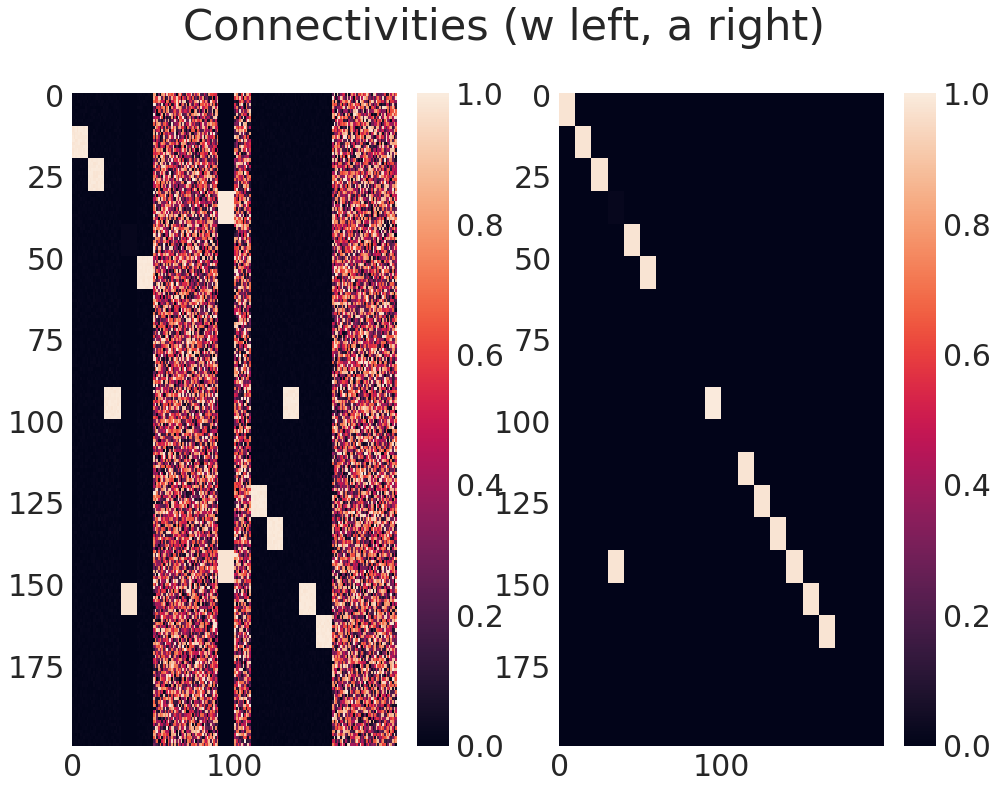

In [4]:
nn.plot_weight_matrices()

In [5]:
success, z_out, z_c3 = nn.test_recall(sequence1)
print('success', success)

success 57.14285714285714


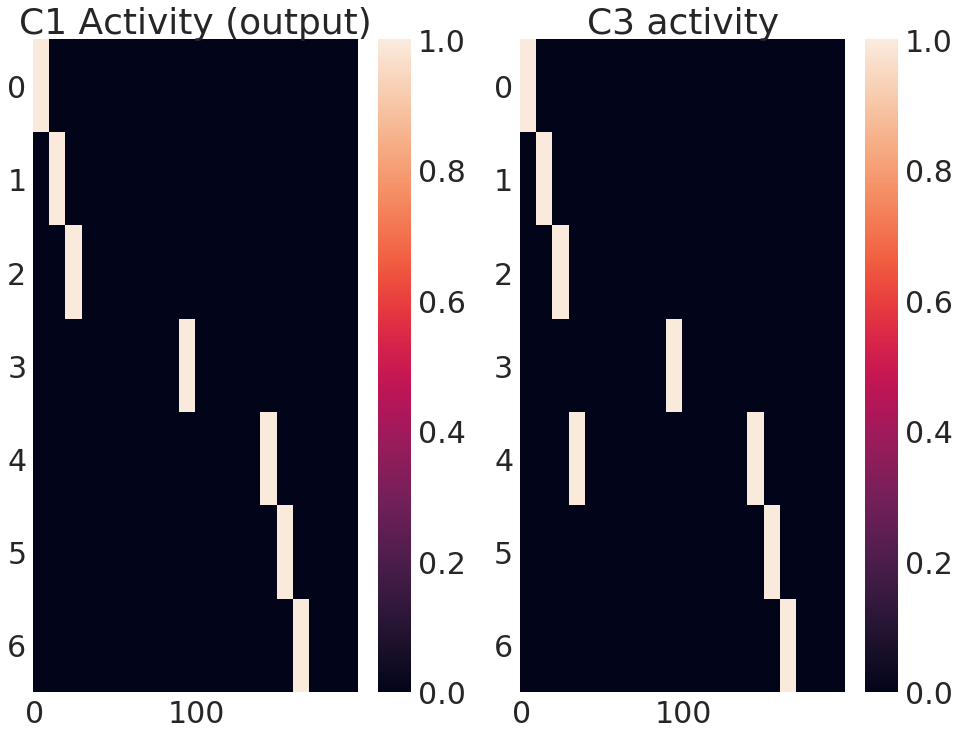

In [6]:
fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(121)
im1 = ax1.imshow(z_out, aspect='auto')

ax1.grid()
ax1.set_title('C1 Activity (output)')

ax2 = fig.add_subplot(122)
im2 = ax2.imshow(z_c3, aspect='auto')

ax2.grid()
ax2.set_title('C3 activity')

fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2);

I realized that the problem is that **I am training first a fully complete sequence and then the other**

I need to stand in 9 and see what this projects to the output of 3 and 14

In [7]:
time = 3
threshold = 0.001

In [8]:
np.where(z_c3[time] > threshold)

(array([90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),)

That is, the C3 activity sits at the intersection, where it should be. Now we want to see what C3 activity will be in the next step **where it should have disambiguated**

In [9]:
vote_c3 = np.dot(nn.GC3 * nn.c1 * nn.w, z_c3[time])

In [10]:
indexes = np.where(vote_c3 > threshold)[0]
print(indexes)

[ 30  31  32  33  34  35  36  37  38  39 140 141 142 143 144 145 146 147
 148 149]


In [11]:
z_c3[time + 1, indexes]

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.])

We see that the update rule (excitation contribution) predicts that the both the pattern 3 and 14 should be activated in C3.

In [12]:
np.where(z_c3[time + 1] > threshold)

(array([ 30,  31,  32,  33,  34,  35,  36,  37,  38,  39, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149]),)

Now what happens with the output at time 4

In [13]:
np.where(z_out[time + 1] > threshold)

(array([140, 141, 142, 143, 144, 145, 146, 147, 148, 149]),)

We see that only pattern 4 survived. To get this pattern we need to see how the activity from C3 at time=4 propagated. 

In [14]:
vote_c1 = np.dot(nn.GC1 * nn.c2 * nn.a, z_c3[time + 1])
print(vote_c1)

[ 0.      0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.0173  0.0173  0.0173  0.0173  0.0173  0.0173  0.0173  0.0173  0.0173
  0.0173  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.      0.
  0

In [15]:
indexes = np.where(vote_c1 > threshold)[0]
print(indexes)

[ 30  31  32  33  34  35  36  37  38  39 140 141 142 143 144 145 146 147
 148 149]


In [16]:
z_out[time + 1, indexes]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.])

## Train two networks one by one 

In [59]:
n_input = 200  # Inputs size
n_recurrent = 200  # C3 size
v = 50.0   # Input - C3 connection
b = 50.0   # Input - C1 connection
Kr = 0.65 # Recurrent self-inhibition gain
Ki = 0.0 # Input - C3 inhibition
Ci = 0.0  # Inhibition from the input to C1
Cr = Kr  # Inhibition from C3 to C1
p =  1.0  # Sparness parameter
p2 = 1.0
w0 = 0.36
uniform_w = False
GC3 = 1.0

# Dynamical parameters
theta = 0.0
phi = 0

# Instantiate the network
nn = MinaNetwork(n_input=n_input, n_recurrent=n_recurrent, p=p, p2=p2, v=v, b=b, Ki=Ki, Kr=Kr, Ci=Ci, Cr=Cr,
                 theta=theta, phi=phi, uniform_w=uniform_w, w0=w0)

# Build the patterns
number_of_patterns = 20
sparsity = 5.0
nn.build_patterns_dictionary(number_of_patterns=number_of_patterns, sparsity=sparsity)

# Training
sequence1 = [ 0,  1,  2, 9,  3,  4,  5]
sequence2 = [11, 12, 13, 9, 14, 15, 16]
sequences = [sequence1, sequence2]
epsilon = 0.02
training_time = 200
pre_synaptic_rule = True

nn.train_network_sequences(epsilon=epsilon, training_time=training_time, sequences=sequences, 
                           pre_synaptic_rule=pre_synaptic_rule)

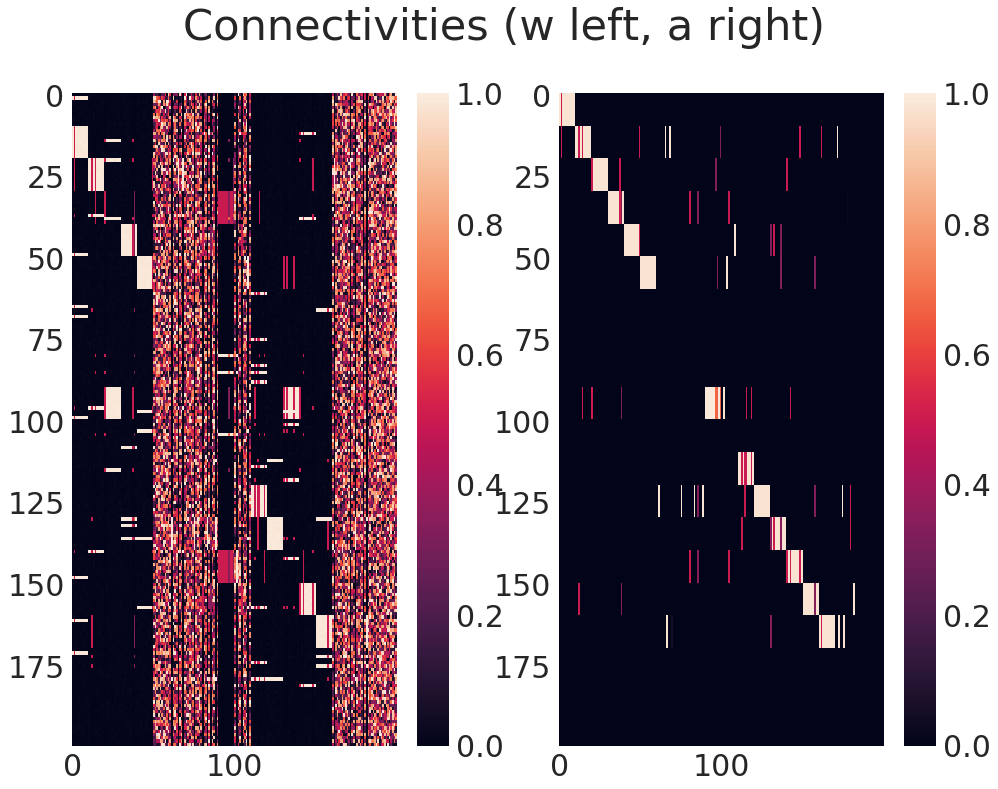

In [60]:
nn.plot_weight_matrices()

Let's extract the connections that point to 3 and 14 besides 90

(0.6, 0.7)

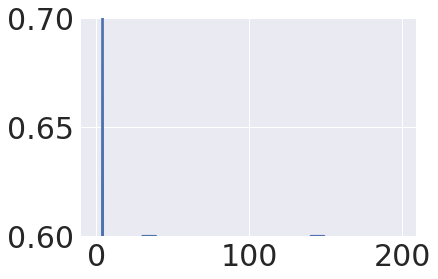

In [52]:
aux = 0.6
nn.w[30:40, 90:100] = aux
nn.w[140:150, 90:100] = aux
plt.plot(nn.w[:, 93])
plt.ylim([0.60, 0.70])


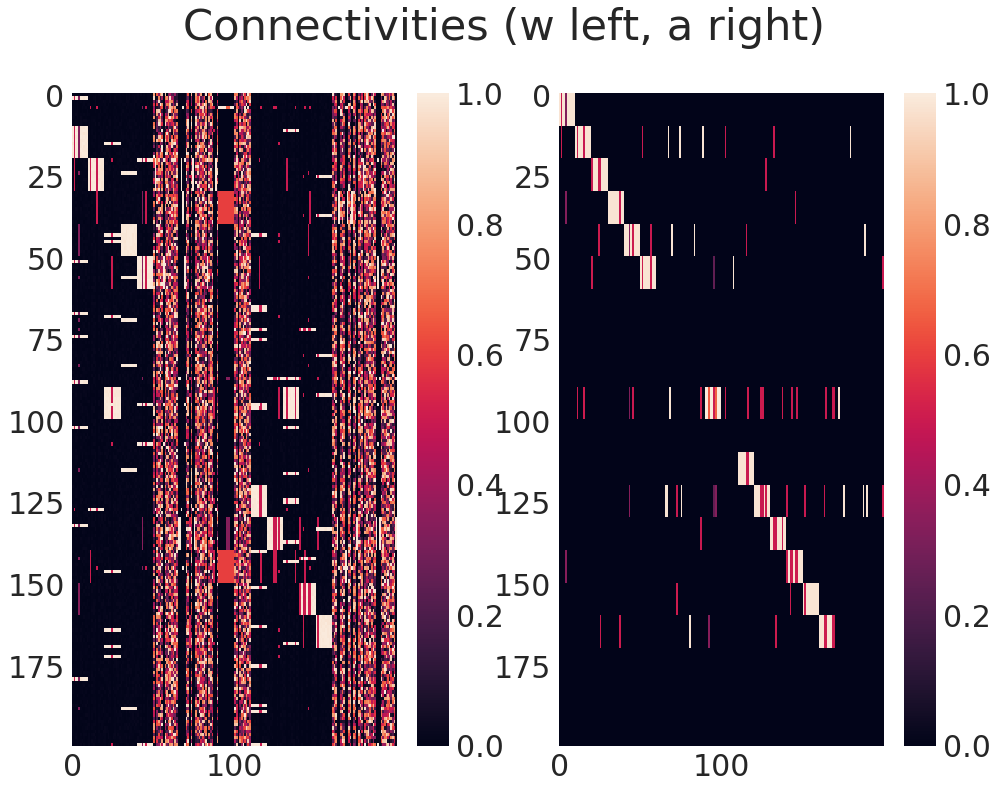

In [53]:
nn.plot_weight_matrices()

In [54]:
support1 = np.where(nn.a[30, :] > 0)[0]
print(support1)

[  4  30  31  32  33  34  35  36  37  38  39 145]


In [55]:
support2 = np.where(nn.a[140, :] > 0)[0]
print(support2)

[  4  75 140 141 142 143 144 145 146 147 148 149]


In [64]:
nn.GC3 = 0.2
nn.GC1 = 0.2
success1, z_out, z_c3 = nn.test_recall(sequence1)
success2, z_out2, z_c32 = nn.test_recall(sequence2)
print('success 1', success1)
print('success 2', success2)

success 1 57.14285714285714
success 2 57.14285714285714


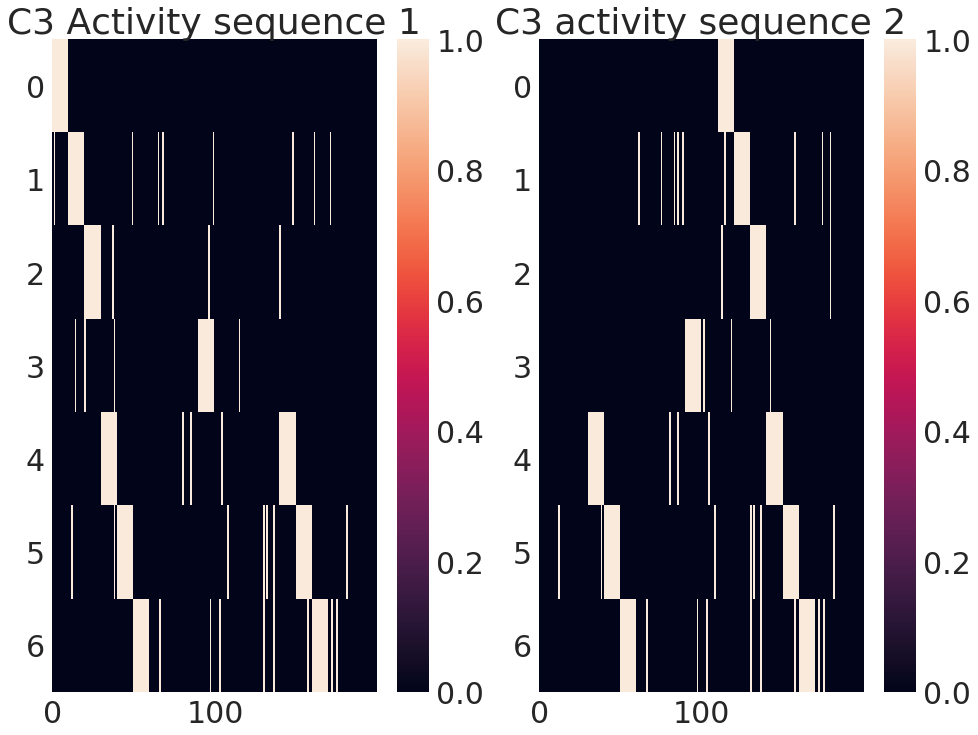

In [65]:
fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(121)
im1 = ax1.imshow(z_c3, aspect='auto')

ax1.grid()
ax1.set_title('C3 Activity sequence 1')

ax2 = fig.add_subplot(122)
im2 = ax2.imshow(z_c32, aspect='auto')

ax2.grid()
ax2.set_title('C3 activity sequence 2')

fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2);

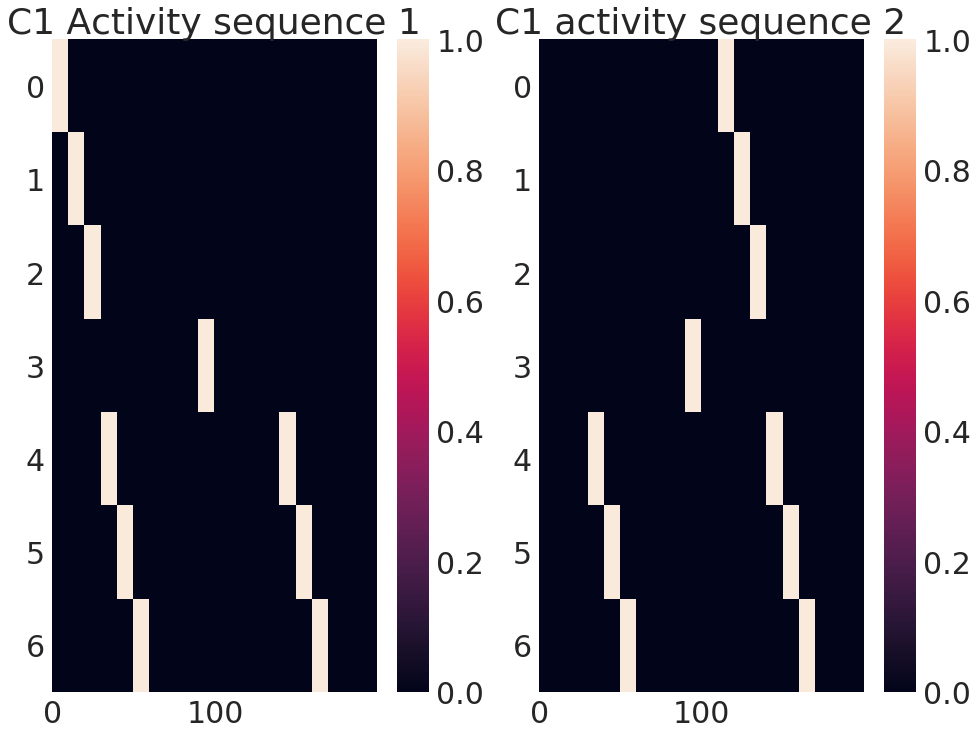

In [66]:
fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(121)
im1 = ax1.imshow(z_out, aspect='auto')

ax1.grid()
ax1.set_title('C1 Activity sequence 1')

ax2 = fig.add_subplot(122)
im2 = ax2.imshow(z_out2, aspect='auto')

ax2.grid()
ax2.set_title('C1 activity sequence 2')

fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2);

In [67]:
success, z_out, z_c3 = nn.test_recall(sequence2)

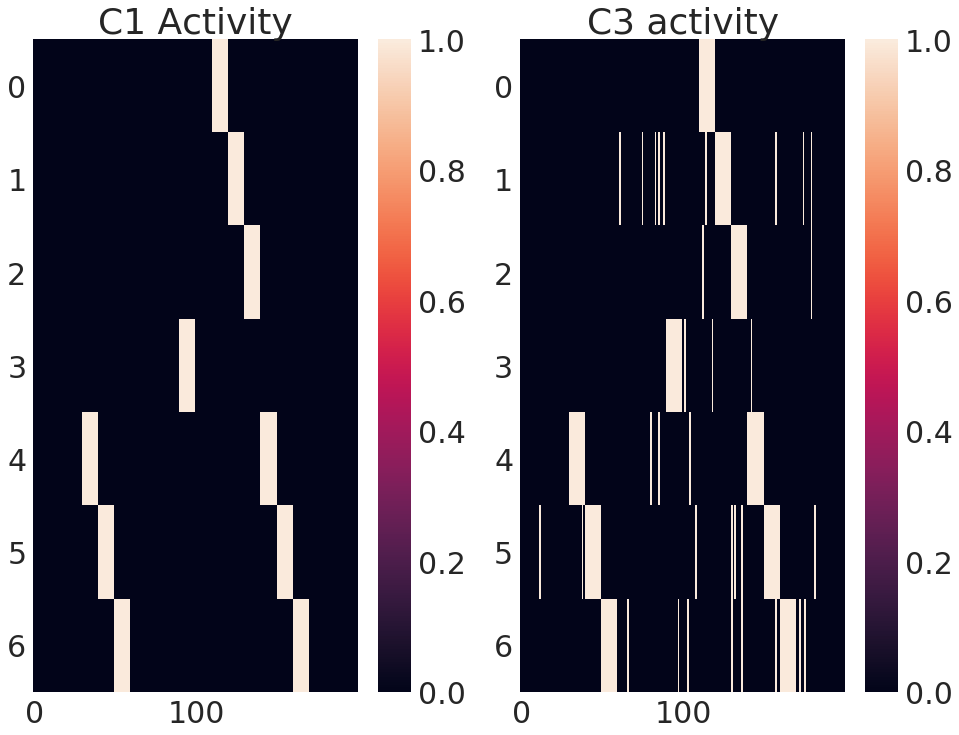

In [68]:
fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(121)
im1 = ax1.imshow(z_out, aspect='auto')

ax1.grid()
ax1.set_title('C1 Activity')

ax2 = fig.add_subplot(122)
im2 = ax2.imshow(z_c3, aspect='auto')

ax2.grid()
ax2.set_title('C3 activity')

fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2);

In [249]:
time = 3
threshold = nn.Kr

In [250]:
z_c3[time] 

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0

In [251]:
np.where(z_c3[time] > threshold)

(array([ 45,  67,  84,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 113]),)

That is, the C3 activity sits at the intersection, where it should be. Now we want to see what C3 activity will be in the next step **where it should have disambiguated**

In [252]:
vote_c3 = np.dot(nn.GC3 * nn.c1 * nn.w, z_c3[time])
print(vote_c3)

[ 0.002   0.0033  0.0049  0.0037  0.0036  0.0027  0.0029  0.0691  0.0035
  0.0036  0.0025  0.0029  0.0038  0.0024  0.958   0.0021  0.0038  0.003
  0.1669  0.0032  0.0689  0.0015  0.0017  0.002   0.0016  0.0015  0.0033
  0.0067  0.0019  0.0038  0.9629  0.9595  0.9609  0.9595  0.9567  0.9613
  0.9576  0.959   0.9583  0.9581  0.0025  0.002   0.003   0.0044  0.004
  0.0031  0.0038  0.005   0.0035  0.0045  0.169   0.169   0.1679  0.1681
  0.1695  0.167   0.1665  0.1697  0.167   0.168   0.0036  0.0012  0.0042
  0.0051  0.1686  0.0019  0.0035  0.004   0.0047  0.0061  0.0058  0.0037
  0.0031  0.0715  0.0018  0.0045  0.005   0.0043  0.006   0.0051  0.0029
  0.0044  0.003   0.0027  0.0056  0.0048  0.0036  0.0047  0.0047  0.0023
  0.0043  0.0049  0.0027  0.0071  0.0029  0.004   0.004   0.001   0.0034
  0.0055  0.004   0.0068  0.0036  0.0026  0.1665  0.002   0.0054  0.0044
  0.0031  0.0034  0.0014  0.0037  0.0041  0.0037  0.0027  0.0042  0.0043
  0.0031  0.0028  0.0018  0.0685  0.0696  0.0707  0.0

In [253]:
z_c3[time].sum() * nn.Kr

0.91000000000000003

In [254]:
nn.GC3

0.2

In [255]:
indexes = np.where(vote_c3 > threshold)[0]
print(indexes)

[  7  14  18  20  30  31  32  33  34  35  36  37  38  39  50  51  52  53
  54  55  56  57  58  59  64  73 104 120 121 122 123 124 125 126 127 128
 129 132 140 141 142 143 144 145 146 147 148 149 160 161 162 163 164 165
 166 167 168 169 181 197 199]


In [256]:
z_c3[time + 1, indexes]

array([ 0.,  1.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

We see that the update rule (excitation contribution) predicts that the both the pattern 3 and 14 should be activated in C3.

In [257]:
np.where(z_c3[time + 1] > threshold)

(array([ 14,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149]),)

Now what happens with the output at time 4

In [258]:
np.where(z_out[time + 1] > threshold)

(array([ 30,  31,  32,  33,  34,  35,  36,  37,  38,  39, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149]),)

We see that only pattern 4 survived. To get this pattern we need to see how the activity from C3 at time=4 propagated. 

In [259]:
vote_c1 = np.dot(nn.GC1 * nn.c2 * nn.a, z_c3[time + 1])
print(vote_c1)

[ 0.      0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.2632  0.2632  0.2632  0.2632  0.2632  0.2632  0.2632  0.2632  0.2632
  0.2632  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      1.7443  1.7443  1.7443  1.7443  1.7443  1.7443  1.7443  1.7443
  1.7443  1.7443  0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.0001  0.0001  0.0001  0.0001  0.0001  0.0001  0.0001
  0.0001  0.0001  0.0001  0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.0667  0.0667  0.0667  0.0667  0.0667  0.0667
  0.0667  0.0667  0.0667  0.0667  0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.099   0.099   0.099   0.099   0.099
  0.099   0.099   0.

In [186]:
indexes = np.where(vote_c1 > threshold)[0]
print(indexes)

[ 10  11  12  13  14  15  16  17  18  19  30  31  32  33  34  35  36  37
  38  39 140 141 142 143 144 145 146 147 148 149]


In [187]:
z_out[time + 1, indexes]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.])

## Let's do more systematic study of the problem

In [124]:
### Structure paramters
n_input = 200  # Inputs size
n_recurrent = 200 # C3 size
v = 21.0   # Input - C3 connection
b = 21.0   # Input - C1 connection
Kr = 0.85   # Recurrent self-inhibition gain
Ki = 0.0  # Input - C3 inhibition
Ci = 0.0  # Inhibition from the input to C1
Cr = 0.85  # Inhibition from C3 to C1
p = 1.0  # Sparness parameter
uniform_w = False

# Dynamical parameters
theta = 0.0
phi = 0

# Build the patterns
number_of_patterns = 20
sparsity = 5.0

# Training
sequence1 = [ 0,  1, 2,  9,  3,  4,  5]
sequence2 = [11, 12, 13, 9, 14, 15, 16]
sequences = [sequence1, sequence2]
epsilon = 0.02
training_time = 200
pre_synaptic_rule = True

dt = 0.05
Kr_vector = np.arange(0.3, 1 + dt, dt)

In [125]:
right_scores_history = []
wrong_scores_history = []

for Kr in Kr_vector:
    Cr = Kr
    # Instantiate the network
    nn = MinaNetwork(n_input=n_input, n_recurrent=n_recurrent, p=p, v=v, b=b, Ki=Ki, Kr=Kr, Ci=Ci, Cr=Cr,
                     theta=theta, phi=phi, uniform_w=uniform_w)
    
    nn.build_patterns_dictionary(number_of_patterns=number_of_patterns, sparsity=sparsity)

    # Training
    nn.train_network_sequences(epsilon=epsilon, training_time=training_time, sequences=sequences, 
                               pre_synaptic_rule=pre_synaptic_rule)   
    
    right_scores = []
    wrong_scores = []

    for sequence in sequences:
        success, z, z_c3 = nn.test_recall(sequence)
        goal_pattern = nn.patterns_dictionary[sequence[-1]]

        # Take the indexes where the pattern has to be active and where not
        wrong_indexes = np.where(goal_pattern == 0)[0]
        right_indexes = np.where(goal_pattern == 1)[0]

        # See if the right indexes are activated and if the wrong indexes are activated
        right_score =  z[-1][right_indexes].sum() 
        wrong_score = z[-1][wrong_indexes].sum()

        right_scores.append(right_score)
        wrong_scores.append(wrong_score)
    
    right_scores_history.append(right_scores)
    wrong_scores_history.append(wrong_scores)

In [126]:
right_scores_history

[[0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0]]

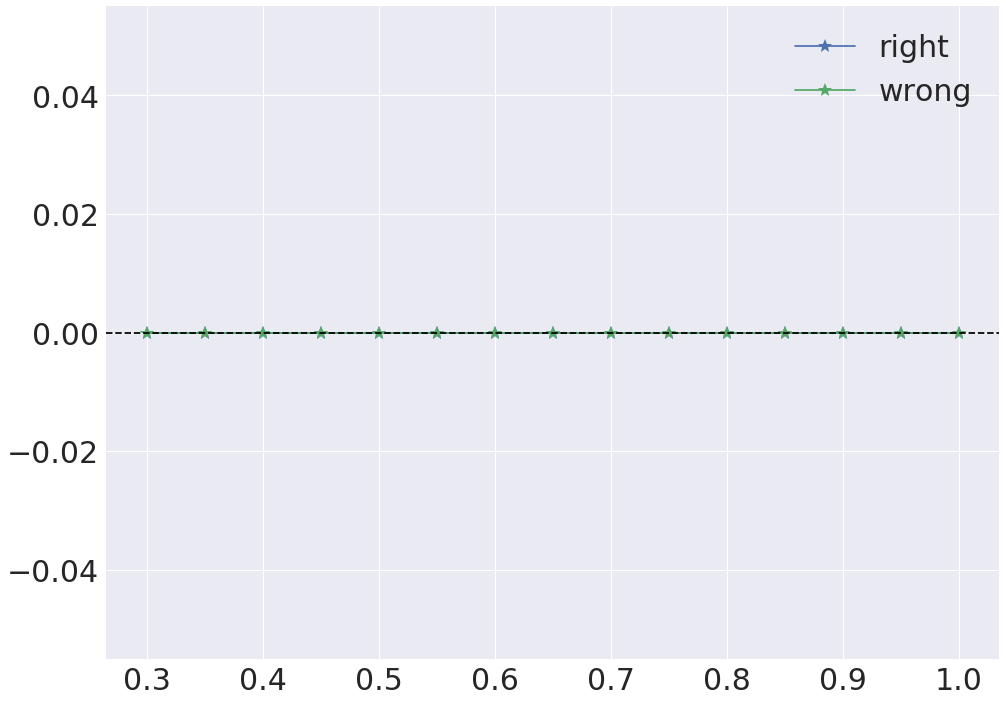

In [127]:
x = np.array(right_scores_history) 
y = np.array(wrong_scores_history)

right_results = np.mean(x, axis=1)
wrong_results = np.mean(y, axis=1)

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)

ax.plot(Kr_vector, right_results, '*-', markersize=15, label='right')
ax.plot(Kr_vector, wrong_results, '*-', markersize=15, label='wrong')

ax.axhline(0, color='black', linestyle='--')

# ax.set_ylim([-0.1, 1.1])
ax.legend();

## Systematic with sparse parameters

In [128]:
n_input = 200  # Inputs size
n_recurrent = 200  # C3 size
v = 35.0   # Input - C3 connection
b = 35.0   # Input - C1 connection
Kr = 0.20  # Recurrent self-inhibition gain
Ki = 0.0 # Input - C3 inhibition
Ci = 0.0  # Inhibition from the input to C1
Cr = Kr  # Inhibition from C3 to C1
p =  0.4  # Sparness parameter
p2 = 0.4
w0 = 0.36
uniform_w = True

# Dynamical parameters
theta = 0.0
phi = 0

# Training
sequence1 = [ 0,  1, 9,  2,  3,  4,  5,  6]
sequence2 = [12, 13, 9, 14, 15, 16, 17, 18]
sequences = [sequence1, sequence2]
epsilon = 0.02
training_time = 200
pre_synaptic_rule = True

dt = 0.01
Kr_vector = np.arange(0.1, 1 + dt, dt)

In [129]:
right_scores_history = []
wrong_scores_history = []

for Kr in Kr_vector:
    Cr = Kr
    # Instantiate the network
    nn = MinaNetwork(n_input=n_input, n_recurrent=n_recurrent, p=p, p2=p2, v=v, b=b, Ki=Ki, Kr=Kr, Ci=Ci, Cr=Cr,
                     theta=theta, phi=phi, uniform_w=uniform_w)
    
    nn.build_patterns_dictionary(number_of_patterns=number_of_patterns, sparsity=sparsity)

    # Training
    nn.train_network_sequences(epsilon=epsilon, training_time=training_time, sequences=sequences, 
                               pre_synaptic_rule=pre_synaptic_rule)   
    
    right_scores = []
    wrong_scores = []

    for sequence in sequences:
        success, z, z_c3 = nn.test_recall(sequence)
        goal_pattern = nn.patterns_dictionary[sequence[-1]]

        # Take the indexes where the pattern has to be active and where not
        wrong_indexes = np.where(goal_pattern == 0)[0]
        right_indexes = np.where(goal_pattern == 1)[0]

        # See if the right indexes are activated and if the wrong indexes are activated
        right_score =  z[-1][right_indexes].sum() 
        wrong_score = z[-1][wrong_indexes].sum()

        right_scores.append(right_score)
        wrong_scores.append(wrong_score)
    
    right_scores_history.append(right_scores)
    wrong_scores_history.append(wrong_scores)

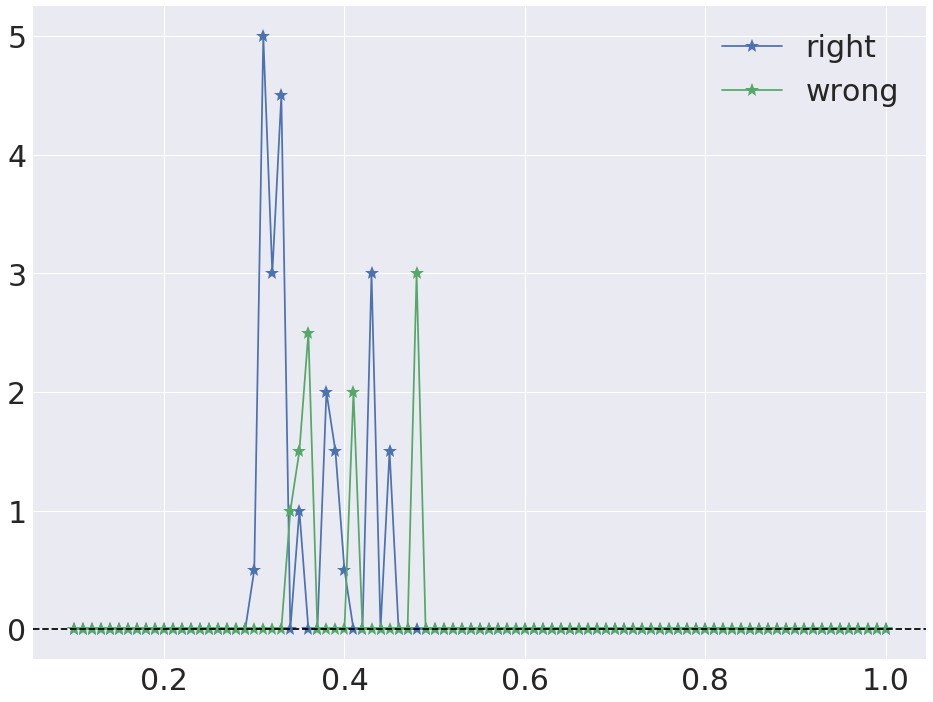

In [130]:
x = np.array(right_scores_history) 
y = np.array(wrong_scores_history)

right_results = np.mean(x, axis=1)
wrong_results = np.mean(y, axis=1)

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)

ax.plot(Kr_vector, right_results, '*-', markersize=15, label='right')
ax.plot(Kr_vector, wrong_results, '*-', markersize=15, label='wrong')

ax.axhline(0, color='black', linestyle='--')

# ax.set_ylim([-0.1, 1.1])
ax.legend();

In [117]:
x.shape

(72, 2)

In [118]:
Kr_vector.shape

(19,)